In [1]:
import tkinter as tk
from tkinter import ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
import numpy as np

In [9]:
def plot_CCD(plot_canvas):
    global canvas,a_entry,b_entry,c_entry
    # get the coefficients from the input fields
    a = float(a_entry.get())
    b = float(b_entry.get())
    c = float(c_entry.get())

    # generate x and y data for the polynomial plot 

    # clear the existing plot from the canvas
    if(canvas):canvas.get_tk_widget().destroy()
    plot_canvas.delete("all")

    # create a Matplotlib figure and plot the polynomial
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"Polynomial Plot: y = {a}x^2 + {b}x + {c}")

    # add the Matplotlib figure to the canvas
    canvas = FigureCanvasTkAgg(fig, master=plot_canvas)
    canvas.draw()
    canvas.get_tk_widget().pack(side="top", fill="both", expand=True)

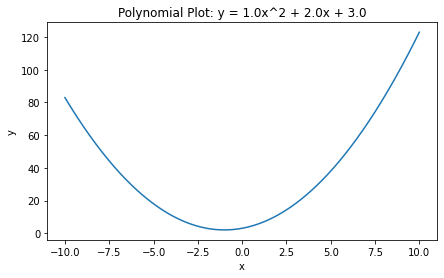

In [6]:

# create the main Tkinter window
root = tk.Tk()

# set the window title
root.title("Polynomial Plotter")

# create the polynomial coefficients input fields
coefficients_frame = ttk.LabelFrame(root, text="Enter the polynomial coefficients:")
coefficients_frame.pack(fill="both", expand=True, padx=10, pady=10)

a_entry = ttk.Entry(coefficients_frame)
a_entry.insert(tk.END, "1.0")
a_entry.pack(side="left", padx=5)

b_entry = ttk.Entry(coefficients_frame)
b_entry.insert(tk.END, "2.0")
b_entry.pack(side="left", padx=5)

c_entry = ttk.Entry(coefficients_frame)
c_entry.insert(tk.END, "3.0")
c_entry.pack(side="left", padx=5)

# create the button to plot the polynomial
plot_button = ttk.Button(root, text="Plot Polynomial")

# create the canvas to display the plot
plot_canvas = tk.Canvas(root, width=400, height=400)
plot_canvas.pack(fill="both", expand=True, padx=10, pady=10)
plot_canvas2 = tk.Canvas(root, width=400, height=400)
plot_canvas2.pack(fill="both",side="right", expand=True, padx=10, pady=10)

canvas=None

def plot_polynomial(plot_canvas):
    global canvas#,plot_canvas,a_entry,b_entry,c_entry
    # get the coefficients from the input fields
    a = float(a_entry.get())
    b = float(b_entry.get())
    c = float(c_entry.get())

    # generate x and y data for the polynomial plot
    x = np.linspace(-10, 10, 1000)
    y = a*x**2 + b*x + c

    # clear the existing plot from the canvas
    if(canvas):canvas.get_tk_widget().destroy()
    plot_canvas.delete("all")

    # create a Matplotlib figure and plot the polynomial
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"Polynomial Plot: y = {a}x^2 + {b}x + {c}")

    # add the Matplotlib figure to the canvas
    canvas = FigureCanvasTkAgg(fig, master=plot_canvas)
    canvas.draw()
    canvas.get_tk_widget().pack(side="top", fill="both", expand=True)

# bind the plot button to the plot_polynomial function
plot_button.config(command=plot_polynomial(plot_canvas))

# add the plot button to the window
plot_button.pack()

# start the main event loop
root.mainloop()


In [127]:
import numpy as np
from scipy.signal import argrelmax
from scipy.ndimage import gaussian_filter

# Generate random 2D data with errors
data = np.load('front.npy')
smoothed_data = gaussian_filter(data, sigma=12, truncate=4)

# Find the indices of all the local maxima in the flattened data array
max_indices = argrelmax(smoothed_data.flatten())[0]

# Convert the flattened indices back to 2D indices
max_indices_2d = np.unravel_index(max_indices, data.shape)

# Find the index of the maximum value among the local maxima
peak_index = np.argmax(smoothed_data[max_indices_2d])

# Get the peak value and its indices
peak_value = smoothed_data[max_indices_2d][peak_index]
peak_indices = (max_indices_2d[0][peak_index], max_indices_2d[1][peak_index])

# Print the peak value and its indices
print("Peak value: {}".format(peak_value))
print("Peak indices: ({}, {})".format(peak_indices[0], peak_indices[1]))

Peak value: 637.4717940316049
Peak indices: (398, 605)


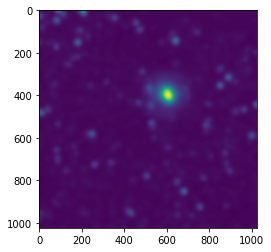

In [128]:
fig,ax=plt.subplots()
ax.imshow(smoothed_data)

In [130]:
print (max_indices_2d)

(array([   0,    0,    0, ..., 1023, 1023, 1023], dtype=int64), array([ 28,  92, 207, ..., 775, 824, 932], dtype=int64))


In [111]:
data.shape

(214, 200)

In [112]:
data[[1,2,3],[4,5,6]]

array([13., 13., 34.])

In [108]:
278+87

365

In [80]:
import pint 
import scipy.constants as C
from scipy.signal import argrelmax
from scipy.ndimage import gaussian_filter

class Spectrum:
    def __init__(self,num):
        self.shot=num
        self.inpoint=354#self.getEnterpos()
        self.e=self.E1(self.inpoint,np.arange(243,985))#energy along pixel
        self.x=self.getDensity()# number density along pixel 
        self.p=self.E1(self.inpoint,np.where(self.x==np.max(self.x))[0][0]+243)# peak energy

    def outx(self,i):#position of pixel i at exit
        return (i-85)*15.5/910+2.45 #cm from pixel 86
    def inx(self,i):#position of pixel i at entrance
        return (i-278)*8.8/214+2 #cm from pixel 279
    
    def E1(self,i,j):
        ee,cc,me=C.elementary_charge,C.speed_of_light,C.electron_mass
        ureg=pint.UnitRegistry()

        y=23#magnet shape in centimeter 
        delta=self.outx(j)-self.inx(i)
        B0=-0.8
        r=(y*y+delta*delta)/(2*delta)# centimeter
        R=r/100#meter
        E=np.sqrt(R*R*ee*ee*B0*B0*cc*cc+me**2*cc*4)# IS
        return ((E*ureg.J).to('MeV')).magnitude #MeV
    def divergence(self,i):#rad
        return np.arctan(((i-395)*8.8/214)/75)
    
    def getDensity(self):
        data=np.load('./Data/exist/'+str(self.shot)+'.npy')
        data=data[:,400:800]
        x=np.sum(data,axis=1)[243:985]
        x0=x-x.min()
        x1=x0/np.sum(x0)
        return x1
    
    def getEnterpos(self):
        data=np.load('./Data/entry/'+str(self.shot)+'.npy')
        smoothed_data = gaussian_filter(data, sigma=12, truncate=4)

        # Find the indices of all the local maxima in the flattened data array
        max_indices = argrelmax(smoothed_data.flatten())[0]#[0] makes tuple become list

        # Convert the flattened indices back to 2D indices
        max_indices_2d = np.unravel_index(max_indices, data.shape)

        # Find the index of the maximum value among the local maxima
        peak_index = np.argmax(smoothed_data[max_indices_2d])

        # Get the peak value and its indices
        peak_value = smoothed_data[max_indices_2d][peak_index]
        peak_indices = (max_indices_2d[0][peak_index], max_indices_2d[1][peak_index])

        return peak_indices[0]



In [133]:
import tkinter as tk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.colors import LogNorm
from tkinter import filedialog, messagebox


class SpectrumPlotter:
    def __init__(self, master):
        self.buffer=[]

        self.master = master
        self.master.title("Spectrum Meter")
        self.master.geometry("1000x650")

        # Create four Entry widgets for inputting parameters
        self.param_frame = tk.Frame(self.master)
        self.param_frame.place(x=20,y=20)#pack(side="left", padx=20, pady=20)
        self.param_entries = []
        for i in range(4):
            if(i==0):
                label = tk.Label(self.param_frame, text=f"Main Shot")
            else:
                label = tk.Label(self.param_frame, text=f"Contrast Shot{i}")
            label.pack()
            entry = tk.Entry(self.param_frame, width=10)
            entry.insert(0, str(29+i))
            entry.pack()
            self.param_entries.append(entry)

        # Create four Canvas widgets for displaying plots
        self.plot_frame = tk.Frame(self.master)
        self.plot_frame.place(x=150,y=20)#pack(side="right", padx=20, pady=20)
        self.figures = []
        for i in range(4):
            fig, ax = plt.subplots()
            canvas = FigureCanvasTkAgg(fig, master=self.plot_frame)
            canvas.get_tk_widget().grid(row=i//2, column=i%2)
            self.figures.append(fig)

        # Create a button for plotting
        plot_button = tk.Button(self.master,width=10,text="Plot", command=self.plot)
        plot_button.place(x=20,y=200)#pack(side="bottom", pady=20)

        plot_button2 = tk.Button(self.master,width=10,text="Save", command=self.save)
        plot_button2.place(x=20,y=250)#pack(side="bottom", pady=20)

    def plot(self):
        # Get input parameters
        params = []
        for entry in self.param_entries:
            try:
                param = int(entry.get())
            except ValueError:
                param = 1  # default value
            params.append(param)
        
        self.buffer.clear()

        # Plot sin functions
        dirofentry='./Data/entry/'
        dirofexist='./Data/exist/'
      
        for i, fig in enumerate(self.figures):
            ax = fig.gca()
            ax.cla()
            # x = np.linspace(-np.pi, np.pi, 100)
            # y = np.sin(params[i] * x)
            # ax.plot(x, y)
            if(i==0):
                # print(dirofentry+str(params[i])+'.npy')
                try:
                    data=np.load(dirofentry+str(params[0])+'.npy')
                except FileNotFoundError:
                    messagebox.showerror("File Not Found", f"The entrydata {str(params[0])+'.npy'} does not exist.")
                ax.imshow(data,norm=LogNorm(),cmap='plasma')
                ax.set_title(f"Image of Entry for Shot{params[0]}")
            elif(i==1):
                # print(dirofexist+str(params[i])+'.npy')
                # with np.load(dirofexist+str(params[i])+'.npy') as data:
                try:
                    data=np.load(dirofexist+str(params[0])+'.npy')
                except FileNotFoundError:
                    messagebox.showerror("File Not Found", f"The existdata {str(params[0])+'.npy'} does not exist.")
                ax.imshow(np.rot90(data),cmap='coolwarm')
                ax.set_title(f"Image of Exist for Shot{params[0]}")
            elif(i==2):
                A=Spectrum(params[0])
                self.buffer.append(A.e)
                self.buffer.append(A.x)
                ax.plot(A.e, A.x)
                ax.set_xlim(70,400)
                ax.set_title('Spectrum',fontsize=10)
                ax.set_xlabel('Energy(MeV)',fontsize=10)
                ax.set_ylabel('Probability Density',fontsize=10)
                ax.axvline(A.p,ls='--',alpha=0.5)
                ax.axhline(np.max(A.x)/2,ls='--',alpha=0.5)
                fig.tight_layout()
            else:
                x = np.linspace(-np.pi, np.pi, 100)
                y = np.sin(params[i] * x)
                ax.plot(x, y)
                ax.set_title(f"Sin Function with Parameter {i+1}")
            fig.canvas.draw()

    def save(self):
        params = []
        for entry in self.param_entries:
            try:
                param = int(entry.get())
            except ValueError:
                param = 1  # default value
            params.append(param)
        
        self.figures[2].savefig(f'./Data/Single plot of Shot{params[0]}.png')
        np.savetxt(f'./Data/spectrum of Shot{params[0]}',self.buffer)


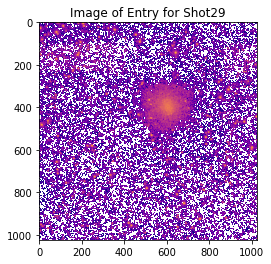

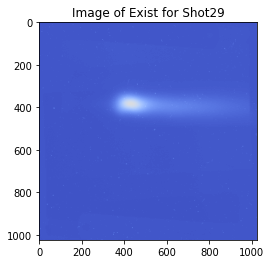

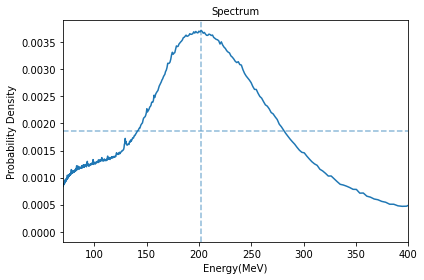

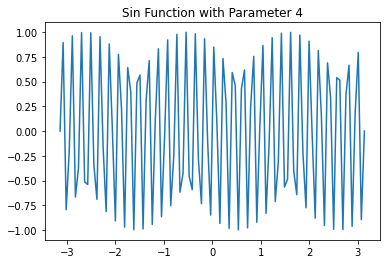

In [135]:
root = tk.Tk()
app = SpectrumPlotter(root)
root.mainloop()

In [136]:
class UI:
    def __init__(self, master):
        self.master = master
        master.title("Hello Button")

        self.label = tk.Label(master, text="")
        self.label.pack()

        self.button = tk.Button(master, text="Say Hello", command=self.say_hello)
        self.button.pack()

    def say_hello(self):
        self.label.config(text="Hello")


In [137]:

root = tk.Tk()
app = UI(root)
root.mainloop()

In [98]:
import os
def dataAccess(metadir):
    datafile=[]
    for root,dirs,files in os.walk(metadir):
        for file in files:
            if file.endswith('.asc'):
                pre=os.path.splitext(file)[0]
                new_name=pre+'.npy'
                if new_name not in files:
                    d=np.genfromtxt(file)
                    data=np.delete(d,0,axis=1)
                    new_path=os.path.join(root,new_name)
                    np.save(new_path,data)
                    datafile.append(new_name)
    print('generated:',datafile)

In [102]:
dataAccess('./Data')

generated: []


In [ ]:
if __name__=='main':
    dataAccess()
    root = tk.Tk()
    app = SpectrumPlotter(root)
    root.mainloop()